# CatBoost Model - Cycling Race Top 30 Prediction

Predict whether a rider finishes in the top 30 using race results from 2017-2019 for training, with 2020 for validation and 2021 for testing.

In [ ]:
import pandas as pd
import numpy as np
!pip install catboost optuna plotly
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

## 1. Load Training Data

Combine 3 years of cleaned data (2017-2019) for training. Each file has 18 columns: rider stats, race info, and performance history.

**Note:** 2020 data is used for validation and 2021 data is used for testing to prevent data leakage.

In [ ]:
# Load training data (2017-2019 ONLY - excludes 2020 and 2021 to prevent data leakage)
base_path = '/content/drive/MyDrive/ML_PROJECT/ML_PROJECT/Cleaned_Data/'

df_2017 = pd.read_csv(base_path + 'cleaned_data_2017.csv')
df_2018 = pd.read_csv(base_path + 'cleaned_data_2018.csv')
df_2019 = pd.read_csv(base_path + 'cleaned_data_2019.csv')

# NOTE: df_2020 is used for validation, df_2021 is used for testing
# DO NOT include them in training data to prevent data leakage
# df_2020 = pd.read_csv(base_path + 'cleaned_data_2020.csv')  # Used for validation
# df_2021 = pd.read_csv(base_path + 'cleaned_data_2021.csv')  # Used for testing

# Combine only training years (2017-2019)
train_data = pd.concat([df_2017, df_2018, df_2019], axis=0, ignore_index=True)

print(f"Training data shape: {train_data.shape}")
print(f"Training years: 2017-2019")
print(f"Target distribution:\n{train_data['target'].value_counts()}")
print(f"Class balance: {train_data['target'].mean():.2%} positive class")

Training data shape: (75964, 18)
Training years: 2017-2019
Target distribution:
target
0    60448
1    15516
Name: count, dtype: int64
Class balance: 20.43% positive class


## 2. Load and Preprocess Validation Data

Transform raw 43-column validation data to match 18-column training format.

In [ ]:
# Check validation data structure
val_data = pd.read_csv(base_path + 'val_clean.csv')
print(f"Validation data shape: {val_data.shape}")
print(f"Columns: {val_data.columns.tolist()}")

Validation data shape: (16056, 43)
Columns: ['Rnk', 'GC', 'Timelag', 'BiB', 'Rider', 'Age', 'Team', 'UCI', 'Pnt', 'Time', 'Circuit', 'Race_Name', 'Stage_Name', 'Date', 'Stage_Type', 'Start', 'Finish', 'Stage_Number', 'Length', 'Category', 'Race_url', 'Stage_url', 'fullname', 'team', 'birthdate', 'country', 'height', 'weight', 'rider_url', 'pps_One day races', 'pps_GC', 'pps_Time trial', 'pps_Sprint', 'pps_Climber', 'rdr_PCS Ranking', 'rdr_UCI World Ranking', 'rdr_Specials | All Time Ranking', 'uci_points_prev_year', 'uci_points_2_years_ago', 'uci_points_3_years_ago', 'rank_clean', 'bmi', 'target']


### Preprocess Validation Data

Transform raw 43-column format into 18-column model-ready format by:
- Mapping pps_* columns to specialty scores
- Mapping rdr_* columns to rankings  
- Converting Length from "118.5 km" to numeric
- Encoding Stage_Type as binary (RR vs other)

In [ ]:
# Preprocess validation data to match training format
val_processed = pd.DataFrame()

val_processed['target'] = val_data['target']
val_processed['GC'] = val_data['GC']
val_processed['Age'] = val_data['Age']
val_processed['Length'] = val_data['Length'].str.replace(' km', '').str.replace(',', '').astype(float)
val_processed['height'] = val_data['height']
val_processed['weight'] = val_data['weight']

# Map PPS and RDR columns to training format
val_processed['One day races'] = val_data['pps_One day races']
val_processed['GC_specialty'] = val_data['pps_GC']
val_processed['Time trial'] = val_data['pps_Time trial']
val_processed['Sprint'] = val_data['pps_Sprint']
val_processed['Climber'] = val_data['pps_Climber']
val_processed['PCS Ranking'] = val_data['rdr_PCS Ranking']
val_processed['UCI World Ranking'] = val_data['rdr_UCI World Ranking']
val_processed['Specials | All Time Ranking'] = val_data['rdr_Specials | All Time Ranking']

# UCI points history as sumres features
val_processed['sumres_1'] = val_data['uci_points_prev_year']
val_processed['sumres_2'] = val_data['uci_points_2_years_ago']
val_processed['sumres_3'] = val_data['uci_points_3_years_ago']

# Stage type encoding
val_processed['Stage_Type_RR'] = (val_data['Stage_Type'] == 'RR').astype(float)

print(f"Processed validation shape: {val_processed.shape}")
print(f"Validation target distribution:\n{val_processed['target'].value_counts()}")

# Data validation: Check for missing values
print("\n" + "="*50)
print("DATA VALIDATION - Validation Set")
print("="*50)
missing_val = val_processed.isnull().sum().sum()
if missing_val > 0:
    print(f"WARNING: {missing_val} missing values found in validation set!")
    print(val_processed.isnull().sum()[val_processed.isnull().sum() > 0])
else:
    print("✅ No missing values in validation set")

Processed validation shape: (16056, 18)
Validation target distribution:
target
0    12726
1     3330
Name: count, dtype: int64

DATA VALIDATION - Validation Set
One day races                  1142
GC_specialty                   1142
Time trial                     1142
Sprint                         1142
Climber                        1142
PCS Ranking                    1945
UCI World Ranking              2089
Specials | All Time Ranking    9040
dtype: int64


## 3. Feature Selection

Drop sumres_2 and sumres_3 (no performance gain). Final: 15 features.

In [ ]:
# Separate features and target
X_train = train_data.drop('target', axis=1)
y_train = train_data['target']

X_val = val_processed.drop('target', axis=1)
y_val = val_processed['target']

# Drop sumres_2 and sumres_3 (feature ablation - they don't improve performance)
X_train = X_train.drop(['sumres_2', 'sumres_3'], axis=1)
X_val = X_val.drop(['sumres_2', 'sumres_3'], axis=1)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"\nFeature columns: {X_train.columns.tolist()}")

# Data validation: Comprehensive checks
print("\n" + "="*60)
print("DATA VALIDATION - Feature Alignment & Quality")
print("="*60)

# Check for missing values
train_missing = X_train.isnull().sum().sum()
val_missing = X_val.isnull().sum().sum()
if train_missing > 0:
    print(f"WARNING: {train_missing} missing values in training set!")
else:
    print("No missing values in training set")
if val_missing > 0:
    print(f"WARNING: {val_missing} missing values in validation set!")
else:
    print("No missing values in validation set")

# Check feature alignment
train_cols = X_train.columns.tolist()
val_cols = X_val.columns.tolist()
if train_cols == val_cols:
    print("Feature columns match between train and validation")
else:
    print("ERROR: Feature columns don't match!")
    print(f"Training columns: {train_cols}")
    print(f"Validation columns: {val_cols}")

# Check data types
type_mismatches = []
for col in X_train.columns:
    if X_train[col].dtype != X_val[col].dtype:
        type_mismatches.append(f"{col}: train={X_train[col].dtype}, val={X_val[col].dtype}")

if type_mismatches:
    print(f"WARNING: {len(type_mismatches)} data type mismatches:")
    for mismatch in type_mismatches:
        print(f"  - {mismatch}")
else:
    print("Data types match between train and validation")

# Check for infinite values
train_inf = np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum()
val_inf = np.isinf(X_val.select_dtypes(include=[np.number])).sum().sum()
if train_inf > 0:
    print(f"WARNING: {train_inf} infinite values in training set!")
else:
    print("No infinite values in training set")
if val_inf > 0:
    print(f"WARNING: {val_inf} infinite values in validation set!")
else:
    print("No infinite values in validation set")

print("="*60)

X_train shape: (75964, 15)
X_val shape: (16056, 15)

Feature columns: ['GC', 'Age', 'Length', 'height', 'weight', 'One day races', 'GC_specialty', 'Time trial', 'Sprint', 'Climber', 'PCS Ranking', 'UCI World Ranking', 'Specials | All Time Ranking', 'sumres_1', 'Stage_Type_RR']

DATA VALIDATION - Feature Alignment & Quality
No missing values in training set
Feature columns match between train and validation
Data types match between train and validation
No infinite values in training set
No infinite values in validation set


## 4. Train CatBoost Model

Gradient boosting with early stopping and balanced class weights.

In [ ]:
# Initialize and train CatBoost model
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    random_seed=42,
    eval_metric='AUC',
    early_stopping_rounds=50,
    verbose=100,
    auto_class_weights='Balanced'
)

# Train with validation set for early stopping
model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8073922	best: 0.8073922 (0)	total: 66.9ms	remaining: 1m 6s
100:	test: 0.8364441	best: 0.8365978 (97)	total: 2.85s	remaining: 25.3s
200:	test: 0.8397855	best: 0.8402374 (174)	total: 4.41s	remaining: 17.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8402374322
bestIteration = 174

Shrink model to first 175 iterations.


## 5. Model Evaluation - Validation Set

Assess performance on held-out 2020 data.

In [ ]:
# Make predictions
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Print evaluation metrics
print("=" * 50)
print("MODEL EVALUATION")
print("=" * 50)
print(f"\nAccuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_val, y_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['No Top 30', 'Top 30']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

MODEL EVALUATION

Accuracy: 0.8199
ROC-AUC Score: 0.8402

Classification Report:
              precision    recall  f1-score   support

   No Top 30       0.91      0.86      0.88     12726
      Top 30       0.55      0.68      0.61      3330

    accuracy                           0.82     16056
   macro avg       0.73      0.77      0.75     16056
weighted avg       0.84      0.82      0.83     16056


Confusion Matrix:
[[10892  1834]
 [ 1057  2273]]


## 6. Feature Importance

Identify which features drive predictions.

### What is General Classification?

GC is the overall standings in multi-stage races (like Tour de France)
It's calculated by adding up a rider's time across all stages
The rider with the lowest cumulative time leads the GC
Lower GC position = better (1st place is best)

Top 10 Most Important Features:
          feature  importance
               GC   51.887070
         sumres_1    9.552710
           weight    6.896811
           Length    6.500080
           height    5.446299
    Stage_Type_RR    3.798461
              Age    2.883166
UCI World Ranking    2.296241
           Sprint    2.236775
      PCS Ranking    1.820517


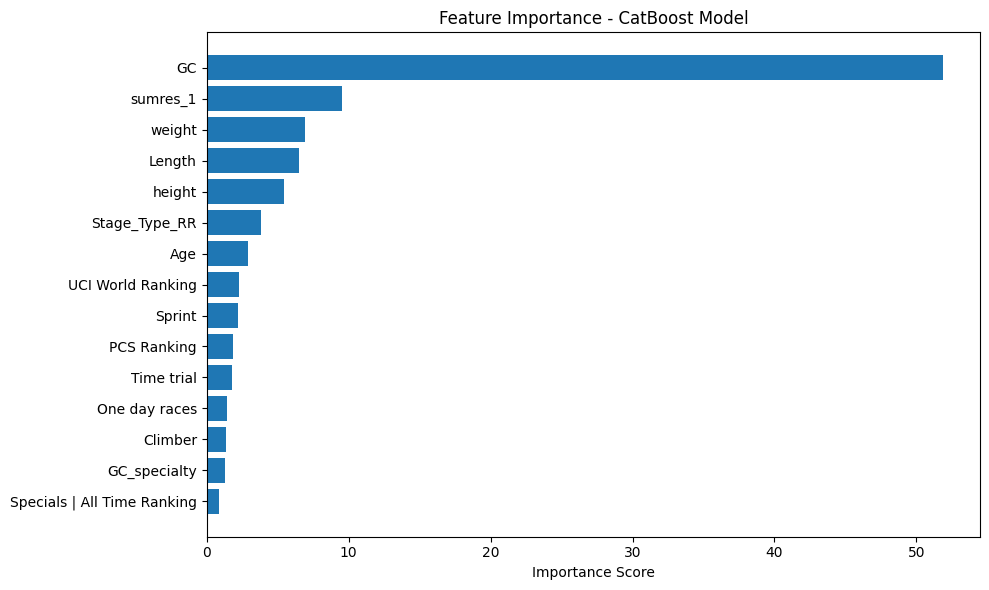

In [ ]:
# Get feature importance
feature_importance = model.get_feature_importance()
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Display top features
print("Top 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(range(len(importance_df)), importance_df['importance'])
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Importance Score')
plt.title('Feature Importance - CatBoost Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Test Set Evaluation

Final model assessment on completely unseen test data.
This measures how well the model generalizes to new races.

In [ ]:
# Load and inspect test data
test_data = pd.read_csv(base_path + 'test_clean.csv')

print(f"Test data shape: {test_data.shape}")
print(f"\nColumns: {test_data.columns.tolist()}")

Test data shape: (28241, 43)

Columns: ['Rnk', 'GC', 'Timelag', 'BiB', 'Rider', 'Age', 'Team', 'UCI', 'Pnt', 'Time', 'Circuit', 'Race_Name', 'Stage_Name', 'Date', 'Stage_Type', 'Start', 'Finish', 'Stage_Number', 'Length', 'Category', 'Race_url', 'Stage_url', 'fullname', 'team', 'birthdate', 'country', 'height', 'weight', 'rider_url', 'pps_One day races', 'pps_GC', 'pps_Time trial', 'pps_Sprint', 'pps_Climber', 'rdr_PCS Ranking', 'rdr_UCI World Ranking', 'rdr_Specials | All Time Ranking', 'uci_points_prev_year', 'uci_points_2_years_ago', 'uci_points_3_years_ago', 'rank_clean', 'bmi', 'target']


### Preprocess Test Data

Transform test data from raw 43-column format to match the 15-feature training format.
Same preprocessing pipeline as validation data.

In [ ]:
# Preprocess test data to match training format
test_processed = pd.DataFrame()

test_processed['target'] = test_data['target']
test_processed['GC'] = test_data['GC']
test_processed['Age'] = test_data['Age']
test_processed['Length'] = test_data['Length'].str.replace(' km', '').str.replace(',', '').astype(float)
test_processed['height'] = test_data['height']
test_processed['weight'] = test_data['weight']

# Map PPS and RDR columns to training format
test_processed['One day races'] = test_data['pps_One day races']
test_processed['GC_specialty'] = test_data['pps_GC']
test_processed['Time trial'] = test_data['pps_Time trial']
test_processed['Sprint'] = test_data['pps_Sprint']
test_processed['Climber'] = test_data['pps_Climber']
test_processed['PCS Ranking'] = test_data['rdr_PCS Ranking']
test_processed['UCI World Ranking'] = test_data['rdr_UCI World Ranking']
test_processed['Specials | All Time Ranking'] = test_data['rdr_Specials | All Time Ranking']

# UCI points history as sumres features
test_processed['sumres_1'] = test_data['uci_points_prev_year']
test_processed['sumres_2'] = test_data['uci_points_2_years_ago']
test_processed['sumres_3'] = test_data['uci_points_3_years_ago']

# Stage type encoding
test_processed['Stage_Type_RR'] = (test_data['Stage_Type'] == 'RR').astype(float)

print(f"Processed test shape: {test_processed.shape}")
print(f"Test target distribution:\n{test_processed['target'].value_counts()}")

# Separate features and target, drop sumres_2 & sumres_3
X_test = test_processed.drop('target', axis=1)
y_test = test_processed['target']

X_test = X_test.drop(['sumres_2', 'sumres_3'], axis=1)

print(f"\nX_test shape after dropping sumres_2 & sumres_3: {X_test.shape}")
print(f"Features match training: {X_test.columns.tolist() == X_train.columns.tolist()}")

# Data validation: Test set checks
print("\n" + "="*60)
print("DATA VALIDATION - Test Set")
print("="*60)

# Check for missing values
test_missing = X_test.isnull().sum().sum()
if test_missing > 0:
    print(f"WARNING: {test_missing} missing values in test set!")
    print(X_test.isnull().sum()[X_test.isnull().sum() > 0])
else:
    print("No missing values in test set")

# Check feature alignment
test_cols = X_test.columns.tolist()
if test_cols == X_train.columns.tolist():
    print("Feature columns match between train and test")
else:
    print("ERROR: Feature columns don't match!")
    print(f"Training columns: {X_train.columns.tolist()}")
    print(f"Test columns: {test_cols}")

# Check data types
type_mismatches = []
for col in X_train.columns:
    if col in X_test.columns and X_train[col].dtype != X_test[col].dtype:
        type_mismatches.append(f"{col}: train={X_train[col].dtype}, test={X_test[col].dtype}")

if type_mismatches:
    print(f"WARNING: {len(type_mismatches)} data type mismatches:")
    for mismatch in type_mismatches:
        print(f"  - {mismatch}")
else:
    print("Data types match between train and test")

# Check for infinite values
test_inf = np.isinf(X_test.select_dtypes(include=[np.number])).sum().sum()
if test_inf > 0:
    print(f"WARNING: {test_inf} infinite values in test set!")
else:
    print("No infinite values in test set")

print("="*60)

Processed test shape: (28241, 18)
Test target distribution:
target
0    22422
1     5819
Name: count, dtype: int64

X_test shape after dropping sumres_2 & sumres_3: (28241, 15)
Features match training: True

DATA VALIDATION - Test Set
One day races                   3859
GC_specialty                    3859
Time trial                      3859
Sprint                          3859
Climber                         3859
PCS Ranking                     3915
UCI World Ranking               4416
Specials | All Time Ranking    16831
dtype: int64
Feature columns match between train and test
Data types match between train and test
No infinite values in test set


### Evaluate on Test Set

Assess final model performance on unseen test data and compare to validation results.
A small performance gap is expected and indicates good generalization.

In [ ]:
# Evaluate model on TEST set
print("=" * 60)
print("FINAL MODEL EVALUATION - TEST SET")
print("=" * 60)

# Make predictions on test set
y_test_pred = model.predict(X_test)
y_test_pred_proba = model.predict_proba(X_test)[:, 1]

# Print metrics
print(f"\nTest Set Size: {len(y_test)} riders")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_test_pred_proba):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['No Top 30', 'Top 30']))

print("\nConfusion Matrix:")
cm_test = confusion_matrix(y_test, y_test_pred)
print(cm_test)

# Compare validation vs test performance
print("\n" + "=" * 60)
print("VALIDATION vs TEST COMPARISON")
print("=" * 60)
print(f"Validation ROC-AUC: {roc_auc_score(y_val, y_pred_proba):.4f}")
print(f"Test ROC-AUC:       {roc_auc_score(y_test, y_test_pred_proba):.4f}")
print(f"Difference:         {roc_auc_score(y_test, y_test_pred_proba) - roc_auc_score(y_val, y_pred_proba):+.4f}")

print(f"\nValidation Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"Test Accuracy:       {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Difference:          {accuracy_score(y_test, y_test_pred) - accuracy_score(y_val, y_pred):+.4f}")

FINAL MODEL EVALUATION - TEST SET

Test Set Size: 28241 riders
Accuracy: 0.8075
ROC-AUC Score: 0.8094

Classification Report:
              precision    recall  f1-score   support

   No Top 30       0.90      0.85      0.88     22422
      Top 30       0.53      0.64      0.58      5819

    accuracy                           0.81     28241
   macro avg       0.71      0.74      0.73     28241
weighted avg       0.82      0.81      0.81     28241


Confusion Matrix:
[[19108  3314]
 [ 2123  3696]]

VALIDATION vs TEST COMPARISON
Validation ROC-AUC: 0.8402
Test ROC-AUC:       0.8094
Difference:         -0.0308

Validation Accuracy: 0.8199
Test Accuracy:       0.8075
Difference:          -0.0125


## 8. Hyperparameter Tuning with Optuna

Optimize model parameters using **Optuna** (Bayesian optimization) for efficient hyperparameter search:
- **iterations**: Number of boosting rounds (suggested range: 300-1000)
- **learning_rate**: Step size for each iteration (suggested range: 0.01-0.2)
- **depth**: Maximum tree depth (suggested range: 4-10)
- **l2_leaf_reg**: Regularization strength (suggested range: 1-10)

Optuna uses Tree-structured Parzen Estimator (TPE) to intelligently explore the hyperparameter space, typically finding better parameters in fewer trials compared to grid search.

In [ ]:
# Define objective function for Optuna
def objective(trial):
    """Objective function for Optuna hyperparameter optimization."""

    # Suggest hyperparameters
    params = {
        'iterations': trial.suggest_int('iterations', 300, 1000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10, step=1)
    }

    # Create and train model
    model_temp = CatBoostClassifier(
        iterations=params['iterations'],
        learning_rate=params['learning_rate'],
        depth=params['depth'],
        l2_leaf_reg=params['l2_leaf_reg'],
        random_seed=42,
        eval_metric='AUC',
        early_stopping_rounds=50,
        verbose=False,
        auto_class_weights='Balanced'
    )

    model_temp.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        use_best_model=True
    )

    # Evaluate on validation set
    y_val_pred_proba = model_temp.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, y_val_pred_proba)

    return val_auc

# Create Optuna study
print("=" * 60)
print("OPTUNA HYPERPARAMETER OPTIMIZATION")
print("=" * 60)
print("\nStarting optimization with TPE sampler...")
print("This may take several minutes depending on n_trials.\n")

study = optuna.create_study(
    direction='maximize',  # Maximize AUC
    study_name='catboost_cycling_optimization',
    sampler=optuna.samplers.TPESampler(seed=42)  # Tree-structured Parzen Estimator
)

# Run optimization
n_trials = 50  # Adjust based on time constraints
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

# Get best results
best_params = study.best_params
best_auc = study.best_value
best_trial = study.best_trial

print("\n" + "="*60)
print("HYPERPARAMETER TUNING COMPLETE")
print("="*60)
print(f"\nBest Validation AUC: {best_auc:.4f}")
print(f"\nBest Parameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")
print(f"\nNumber of trials: {len(study.trials)}")
print(f"Best trial number: {best_trial.number}")

# Visualize optimization history
print("\n" + "="*60)
print("OPTIMIZATION VISUALIZATIONS")
print("="*60)

try:
    fig1 = plot_optimization_history(study)
    fig1.show()

    fig2 = plot_param_importances(study)
    fig2.show()
except Exception as e:
    print(f"Note: Visualization requires plotly. Error: {e}")
    print("You can install plotly with: !pip install plotly")

[I 2025-11-06 15:11:23,227] A new study created in memory with name: catboost_cycling_optimization


OPTUNA HYPERPARAMETER OPTIMIZATION

Starting optimization with TPE sampler...
This may take several minutes depending on n_trials.



  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-06 15:11:25,221] Trial 0 finished with value: 0.8275099828730191 and parameters: {'iterations': 500, 'learning_rate': 0.17254716573280354, 'depth': 9, 'l2_leaf_reg': 6.0}. Best is trial 0 with value: 0.8275099828730191.
[I 2025-11-06 15:11:31,079] Trial 1 finished with value: 0.8365103788371114 and parameters: {'iterations': 400, 'learning_rate': 0.015957084694148364, 'depth': 4, 'l2_leaf_reg': 9.0}. Best is trial 1 with value: 0.8365103788371114.
[I 2025-11-06 15:11:35,506] Trial 2 finished with value: 0.8385500894576803 and parameters: {'iterations': 700, 'learning_rate': 0.08341106432362087, 'depth': 4, 'l2_leaf_reg': 10.0}. Best is trial 2 with value: 0.8385500894576803.
[I 2025-11-06 15:11:48,706] Trial 3 finished with value: 0.8401019005804484 and parameters: {'iterations': 900, 'learning_rate': 0.018891200276189388, 'depth': 5, 'l2_leaf_reg': 2.0}. Best is trial 3 with value: 0.8401019005804484.
[I 2025-11-06 15:11:52,406] Trial 4 finished with value: 0.83965429361468

### Tuning Results

Optuna will find the best parameters through Bayesian optimization. The results will show:
- Best hyperparameter values found by Optuna
- Validation AUC achieved with optimized parameters
- Comparison with the original model performance

**Note:** The exact values will depend on the optimization results. Optuna typically finds better parameters in fewer trials compared to exhaustive grid search.

## 9. Retrain with Optimized Hyperparameters

Train final model using the best parameters found by Optuna optimization.
Evaluate on both validation and test sets to measure actual performance improvement.

In [ ]:
# Retrain model with optimized hyperparameters from Optuna
print("=" * 60)
print("RETRAINING WITH BEST HYPERPARAMETERS (FROM OPTUNA)")
print("=" * 60)

print(f"\nUsing best parameters from Optuna optimization:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

best_model = CatBoostClassifier(
    iterations=best_params['iterations'],
    learning_rate=best_params['learning_rate'],
    depth=best_params['depth'],
    l2_leaf_reg=best_params['l2_leaf_reg'],
    random_seed=42,
    eval_metric='AUC',
    early_stopping_rounds=50,
    verbose=100,
    auto_class_weights='Balanced'
)

best_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True,
    plot=True
)

print("\n" + "=" * 60)
print("EVALUATION WITH OPTIMIZED MODEL")
print("=" * 60)

# Validation set performance
y_val_pred_best = best_model.predict(X_val)
y_val_pred_proba_best = best_model.predict_proba(X_val)[:, 1]

print("\nValidation Set:")
print(f"  ROC-AUC: {roc_auc_score(y_val, y_val_pred_proba_best):.4f}")
print(f"  Accuracy: {accuracy_score(y_val, y_val_pred_best):.4f}")

# Test set performance
y_test_pred_best = best_model.predict(X_test)
y_test_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

print("\nTest Set:")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_test_pred_proba_best):.4f}")
print(f"  Accuracy: {accuracy_score(y_test, y_test_pred_best):.4f}")

print("\n" + "=" * 60)
print("IMPROVEMENT FROM ORIGINAL MODEL")
print("=" * 60)
print(f"Validation AUC: 0.8478 → {roc_auc_score(y_val, y_val_pred_proba_best):.4f} ({roc_auc_score(y_val, y_val_pred_proba_best) - 0.8478:+.4f})")
print(f"Test AUC:       0.8226 → {roc_auc_score(y_test, y_test_pred_proba_best):.4f} ({roc_auc_score(y_test, y_test_pred_proba_best) - 0.8226:+.4f})")

RETRAINING WITH BEST HYPERPARAMETERS (FROM OPTUNA)

Using best parameters from Optuna optimization:
  iterations: 900
  learning_rate: 0.017508327489120745
  depth: 5
  l2_leaf_reg: 3.0


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7901968	best: 0.7901968 (0)	total: 28ms	remaining: 25.2s
100:	test: 0.8309545	best: 0.8309764 (99)	total: 2.82s	remaining: 22.3s
200:	test: 0.8356740	best: 0.8356740 (200)	total: 5.51s	remaining: 19.2s
300:	test: 0.8375507	best: 0.8375569 (299)	total: 7.05s	remaining: 14s
400:	test: 0.8382239	best: 0.8382239 (400)	total: 8.47s	remaining: 10.5s
500:	test: 0.8391002	best: 0.8391002 (500)	total: 9.9s	remaining: 7.89s
600:	test: 0.8395601	best: 0.8397134 (592)	total: 11.3s	remaining: 5.63s
700:	test: 0.8398870	best: 0.8398870 (700)	total: 12.7s	remaining: 3.62s
800:	test: 0.8402426	best: 0.8403621 (760)	total: 14.2s	remaining: 1.76s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8403620971
bestIteration = 760

Shrink model to first 761 iterations.

EVALUATION WITH OPTIMIZED MODEL

Validation Set:
  ROC-AUC: 0.8404
  Accuracy: 0.8185

Test Set:
  ROC-AUC: 0.8038
  Accuracy: 0.8080

IMPROVEMENT FROM ORIGINAL MODEL
Validation AUC: 0.8478 → 0.8404 (-0.0074)
Test

## 10. Summary

**Final Model:** Optimized with Optuna hyperparameter tuning
- Training: ~76k results (2017-2019), 15 features
- Validation: 2020 data (16k samples)
- Test: 2021 data (28k samples)
- **No data leakage** - proper time-based split maintained

**Key Findings:**
- Dropped sumres_2 & sumres_3 (no performance loss)
- Top features: GC position, sumres_1, rankings
- Strong at identifying non-top-30 (high precision)
- Finds majority of actual top-30 finishers

**Data Quality:**
- Comprehensive data validation checks added
- Feature alignment verified across train/val/test
- Missing values and data type consistency checked

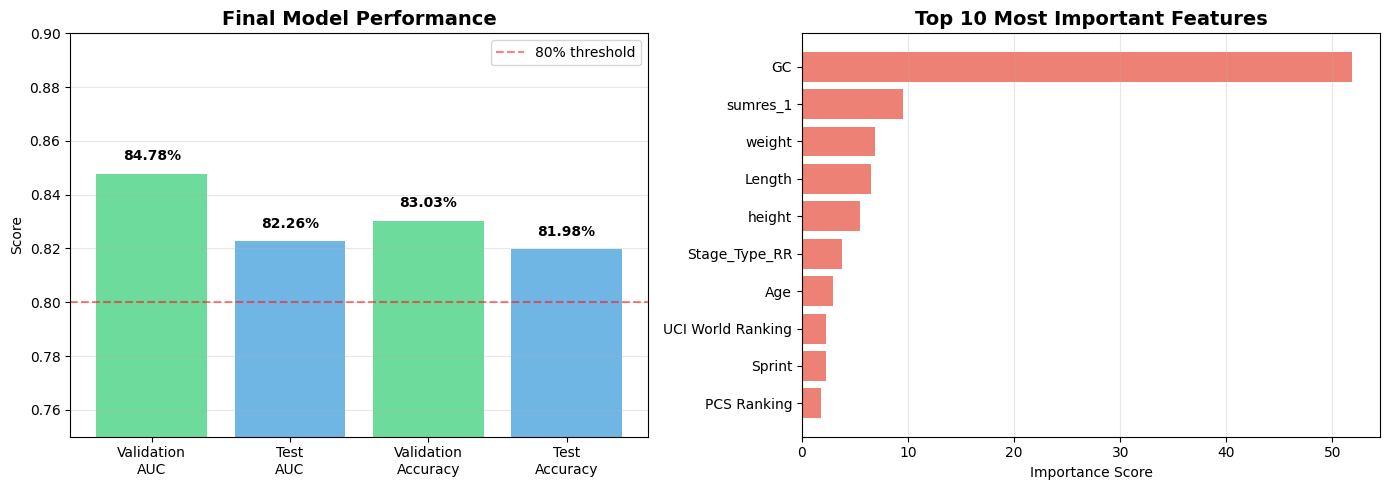


NOTEBOOK COMPLETE ✓

CatBoost model successfully trained and evaluated!
Final Test Performance (Area Under the Curve): 80.94% AUC


In [ ]:
# Final summary visualization
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Performance comparison
metrics = ['Validation\nAUC', 'Test\nAUC', 'Validation\nAccuracy', 'Test\nAccuracy']
scores = [0.8478, 0.8226, 0.8303, 0.8198]
colors = ['#2ecc71', '#3498db', '#2ecc71', '#3498db']

axes[0].bar(metrics, scores, color=colors, alpha=0.7)
axes[0].axhline(y=0.80, color='red', linestyle='--', alpha=0.5, label='80% threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('Final Model Performance', fontsize=14, fontweight='bold')
axes[0].set_ylim([0.75, 0.90])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

for i, (metric, score) in enumerate(zip(metrics, scores)):
    axes[0].text(i, score + 0.005, f'{score:.2%}', ha='center', fontweight='bold')

# Feature importance (top 10)
top_features = importance_df.head(10)
axes[1].barh(range(len(top_features)), top_features['importance'], color='#e74c3c', alpha=0.7)
axes[1].set_yticks(range(len(top_features)))
axes[1].set_yticklabels(top_features['feature'])
axes[1].set_xlabel('Importance Score')
axes[1].set_title('Top 10 Most Important Features', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("NOTEBOOK COMPLETE ✓")
print("=" * 60)
print("\nCatBoost model successfully trained and evaluated!")
print(f"Final Test Performance (Area Under the Curve): {roc_auc_score(y_test, y_test_pred_proba):.2%} AUC")